In [49]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Chapter 15. Autoencoders

## * Autoencoder 
### : 비지도학습(라벨화된 학습데이터 사용 x)에서 입력 데이터의 효율적인 재형성(coding)이 가능한 인공신경망

### - 보통 conding은 입력데이터보다 더 낮은 차원을 가지기 때문에 autoencoder는 차원축소에 유용하게 사용됨
### - autoencoder의 기능 
- 강력한 특징 탐지기 
- Deep Neural Network의 비지도 선행학습 
- 학습 데이터와 비슷한 새로운 데이터 생성 (generative model)



### - autoencoder는 간단하게 입력을 출력으로 복사하는 것을 학습하여 작동함 
- 간단해보이지만 네트워크를 다양한 방법으로 제약(constraining)하여 autoencoder가 바로 입력을 출력으로 복사하지 않게 함 
    - 내부 재형성의 크기를 줄임
    - 입력에 노이즈를 주고 원본을 출력하도록 학습 


### - coding은 제약 속에서 autoencoder가 항등함수를 학습할 때 생기는 부산물이다  

#### 이번장에서는 
- autoencoder의 작동원리 
- 적용할 수 있는 제약의 종류 
- Tensorflow를 통해 autoencoder 구현 
    - 차원 축소 
    - 특징 추출 
    - 비지도 선행학습 
    - 생성 모델 

## Efficient Data Representations 

- 긴 데이터라도 특징이 있다면 기억하기 쉬워지며, 다시 작성도 쉬워진다 
- 긴 연속숫자들을 암기하기 어렵다는 사실은 그 데이터의 패턴을 인식하기 유용하게 만든다 
    - 이것은 autoencoder의 학습 동안 데이터의 패턴을 발견하고 활용하도록 제약을 두는 이유이다 
    
    
- 전문가들이 밝혀내기를, 체스전문플레이어들은 일반인들과 달리 보드를 5초만 봐도 게임의 모든 부분의 위치를 기억할 수 있다 
    - 이것은 부분들이 각각 임의가 아닌 서로 연관된 위치에 놓여있기 때문 
    - 일반인보다 기억력이 좋은것이 아니라 일반인보다 많은 체스 경험이 패턴을 파악하기에 쉬웠던 것 
    - 패턴을 알아차리는 것은 정보를 효율적으로 저장하도록 도움 
    

- 예시와 같이 autoencoder는 입력을 파악하고 그것을 효율적인 내부 재형성으로 변환하고 그것을 입력과 매우 비슷한 출력으로 나타내는 것 

### - autoencoder는 항상 두 부분으로 구성 
#### - encoder (인식 네트워크)
- 입력을 내부 재형성으로 변환 


#### - decoder (생성 네트워크)
- 내부 재형성을 출력으로 변환 

### - autoencoder는 다층퍼셉트론과 같은 구조를 가짐 
####  하지만 반드시 입력층의 뉴런 개수와 출력층의 뉴런 개수가 같아야 함 
<img src = "image\ch15\chess.png">
- 한개의 은닉층은 2개의 뉴런(encoder)으로 구성  
- 출력층은 3개의 뉴런(decoder)으로 구성


#### - 출력은 autoencdoer가 입력을 재형성하려 시도할 때 종종 복원(reconstructions)이라 불림 
#### - 비용함수는 복원이 입려과 다를 때 모델에 벌을 주기 위한 복원 손실을 포함함 

### - Undercomplete
-  : 내부 재형성이 입력 데이터보다 낮은 차원을 가짐 
- undercomplete autoencoder는 입력을 coding에 바로 그대로 복사하지 못하기 때문에 입력을 출력에 어떻게 복사할 것인지 찾아야 함
    - 입력 데이터의 중요하지 않은 특징들은 버리고 가장 중요한 특징들만을 학습할 수 밖에 없음 
    

## Performing PCA with and Undercomplete Linear Autoencoder

- 만약 autoencoder가 선형활성화 함수만 사용하고 비용함수로 MSE를 사용한다면 결국 PCA를 수행해 끝날 것을 보여줌 

#### - 3차원 데이터를 2차원에 영사시키는 PCA를 수행하는 간단한 선형 autoencoder

In [50]:
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

n_inputs = 3 #3차원 입력 
n_hidden = 2 #2차원으로 encoding
n_outputs = n_inputs #출력층의 노드 개수는 입력층의 노드 개수와 동일해야함 

learning_rate = 0.01

#그래프 만들기 
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = fully_connected(X, n_hidden, activation_fn=None) #입력층-은닉층
outputs = fully_connected(hidden, n_outputs, activation_fn=None) #은닉층-출력층 

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) #비용함수 MSE

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss) #reconstruction_loss를 최소화시키도록 학습 

init = tf.global_variables_initializer()

- MLP와 매우 비슷한 구조지만 조금 다름 
    - 출력의 개수는 입력의 개수와 같음 
    - 간단한 PCA를 수행하기 위해서, activation_fn=None으로, 비용함수를 MSE로 설정 
    
#### - 데이터를 불러와 학습셋에 대해 모델을 학습하고 테스트셋 재형성에 사용 

In [51]:
import numpy as np
import numpy.random as rnd

#데이터 만들기 
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

In [52]:
data

array([[ -1.02592185e+00,  -6.03764035e-01,  -3.61779903e-01],
       [ -4.78796397e-03,   6.76237786e-01,   3.36012274e-01],
       [ -1.06729408e+00,  -5.66900983e-01,  -3.30641113e-01],
       [ -8.62849091e-01,   1.34195014e-01,   3.32310710e-02],
       [ -7.70945331e-01,   2.48766682e-01,  -1.02861880e-01],
       [  1.06412364e+00,   4.26245815e-01,   3.00885052e-01],
       [ -9.65619888e-01,  -6.03557812e-01,  -2.66196063e-01],
       [  5.88804093e-01,  -3.65103013e-01,   1.09935587e-01],
       [  1.09173117e+00,   4.34543182e-01,   3.17925292e-01],
       [  4.49754726e-01,   7.79687003e-01,   1.93815940e-01],
       [ -1.02235571e+00,  -5.44024678e-02,  -8.34171502e-02],
       [  1.14286245e+00,   3.19490139e-01,   1.46882802e-01],
       [ -1.00702813e+00,  -2.38331713e-01,  -1.50191559e-01],
       [ -9.11372244e-01,  -5.55093729e-01,  -1.01202740e-01],
       [  1.17844560e+00,   1.71149025e-01,   3.28981558e-01],
       [ -3.06034060e-01,   5.47607256e-01,   1.5415162

In [53]:
data.shape 

(200, 3)

In [55]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100]) #100개씩
X_test = scaler.transform(data[100:])

In [56]:
X_train.shape

(100, 3)

In [57]:
X_test.shape

(100, 3)

In [58]:
n_iterations = 1000
codings = hidden #은닉층의 출력이 coding을 제공 

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations): #1000번 
        training_op.run(feed_dict={X: X_train}) #학습데이터 학습
    codings_val = codings.eval(feed_dict={X: X_test})  #테스트데이터 encoding

In [59]:
codings_val.shape  #속성을 2개로 줄임 

(100, 2)

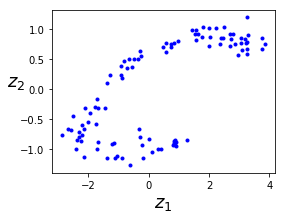

In [60]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,3))

plt.plot(codings_val[:,0], codings_val[:, 1], "b.")

plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.show()

<img src = "image\ch15\pca.png">

## Stacked Autoencoders
#### : 여러개의 은닉층을 가진 autoencoder, deep autoencoder라고도 함 

### - autoencoder도 다른 신경망과 같이 여러개의 은닉층을 가질 수 있음 
#### - 하지만 autoencoder를 너무 강력하게 만들어서는 안됨 
- 분명 autoencoder가 학습데이터를 완벽하게 재형성할 것이지만 과정동안 어떠한 유용한 데이터도 학습하지 못하고 새로운 데이터도 잘 생성하지 못함 


### - Stacked autoencoder의 구조는 보통 중앙 은닉층에 관해서 대칭 
<img src = "image\ch15\stackedae.png">
- MNIST 데이터 사용
- 입력층의 뉴런은 784개 
- 다음 은닉층은 300개의 뉴런 
- 중앙 은닉층은 150개의 뉴런 
- 그 다음 은닉층은 300개의 뉴런 
- 출력층의 뉴런은 784개 


### Tensorflow Implementation
#### - MNIST 데이터에 stacked autoencoder 사용 
- He initialization, ELU 활성화함수, L2 제약 사용 
- 비지도학습이기 때문에 라벨(y)가 없는 것을 제외하고는 예전에 살펴본 코드와 비슷함

In [87]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [88]:
reset_graph()

n_inputs = 28 * 28 #입력 784개
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1 #똑같이 300개 
n_outputs = n_inputs  #똑같이 784개

learning_rate = 0.01
l2_reg = 0.0001

#그래프 만들기 
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
with tf.contrib.framework.arg_scope([fully_connected], 
                                   activation_fn=tf.nn.elu, #ELU활성화 함수 
                                   weights_initializer=tf.contrib.layers.variance_scaling_initializer(), #He initialization
                                   weights_regularizer=tf.contrib.layers.l2_regularizer(l2_reg)): #l2 제약 
    hidden1 = fully_connected(X, n_hidden1)
    hidden2 = fully_connected(hidden1, n_hidden2)
    hidden3 = fully_connected(hidden2, n_hidden3)
    outputs = fully_connected(hidden3, n_outputs, activation_fn=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) #복원 loss : MSE 

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses) #최종 loss는 둘을 더한것 

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [89]:
n_epochs = 5
batch_size = 150

#실행 
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown

0 Train MSE: 0.0208554
1 Train MSE: 0.0113726
2 Train MSE: 0.0102246
3 Train MSE: 0.00990046
4 Train MSE: 0.0103758


In [68]:
mnist.train.num_examples

55000

### Tying Weights 
#### - autoencoder가 딱 대칭적일 때, 흔한 기술은 decoder층의 가중치와 encoder층의 가중치를  묶는것이다 
- 모델의 가중치 개수가 반이 됨 
    - 학습 속도가 빨라짐 
    - 오버피팅 위험을 제한함 
    
    
- autoencoder가 입력층을 제외하고 총 N개의 레이어를 가질 때 
    - 1번째 레이어는 첫번째 은닉층, 중간(N/2) 레이어는 coding레이어, 마지막(N) 레이어는 출력레이어
    - WL :L번째 레이어의 연결 가중치를 의미 
     <img src = "image\ch15\tying.png">
    
        - 대칭되는 레이어의 가중치는 전치 관계 
        - W4 = W1^T
        - W3 = W2^T
        - W2 = W3^T
        - W1 = W4^T
        
        
#### - 하지만 Tensorflow에서 fully_connected()를 사용해서 묶인 가중치를 구현하는 것은 복잡함 
- 하나씩 레이어를 정의하는 것이 더 쉬움 


In [70]:
activation = tf.nn.elu #ELU 활성화함수 
regularizer = tf.contrib.layers.l2_regularizer(l2_reg) #L2 제약
initializer = tf.contrib.layers.variance_scaling_initializer() #He initialization

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

#2개만 
weights1_init = initializer([n_inputs, n_hidden1]) 
weights2_init = initializer([n_hidden1, n_hidden2])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.transpose(weights2, name="weights3")  # weight2를 전치 
weights4 = tf.transpose(weights1, name="weights4")  # weight1을 전치 

#bias
biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) #복원 loss
reg_loss = regularizer(weights1) + regularizer(weights2)
loss = reconstruction_loss + reg_loss #loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

- 가중치3과 가중치4는 variable이 아니고 각각 가중치2와 가중치 1을 전치한 것 (서로 묶임)
- 둘은 variable이 아니기 때문에 제약(regularizing)을 사용하지 않음 (가중치1, 가중치2에만 사용)
- bias는 절대 서로 묶이지 않으며 제약하지 않음

In [72]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)

0 Train MSE: 0.013255
1 Train MSE: 0.00795071
2 Train MSE: 0.0074879
3 Train MSE: 0.00736283
4 Train MSE: 0.00717537


## Training One Autoencoder at a Time
#### - 한번에 전체 stacked autoencoder를 학습하는 것보다, 얕은 autoencoder를 하나씩 학습한 후 합치는 것이 더 빠름 
<img src = "image\ch15\oneattime.png">
- 단계1의 학습 동안, 첫번째 autoencoder는 입력을 복원하는 것을 학습함 
- 단계2의 학습 동안, 두번째 autoencoder는 autoencoder의 첫번째 은닉층의 출력을 복원하는 것을 학습함 
- 최종적으로 두 단계를 쌓으면 하나의 큰 stacked autoencoder가 됨 


#### - 다단계 알고리즘의 학습을 구현하는 방법 
- 가장 간단한 방법은 각 단계마다 다른 tensorflow 그래프를 사용하는 것 
    - autoencoder의 학습 후에 학습셋을 실행하고 은닉층의 출력을 포착
    - 은닉층의 출력은 다음 autoencoder의 학습셋이 됨
    - 모든 autoencoder이 이런 방식으로 학습되면 각 autoencoder의 가중치와 bias를 복사하여 stakced autoencoder를 생성한다 
    
    
- 전체 stacked autoencoder를 포함하는 하나의 tensorflow 그래프를 사용하는 것 
    - 각 학습 단계를 수행하기 위해 추가적인 동작이 필요 
<img src = "image\ch15\stackedae2.png">
- 중앙은 전체 stacked encoder로, 학습 후에 사용 
- 왼쪽 
    - 학습의 단계1에서 수행되어야 할 동작 
    - 은닉층2와 은닉층3을 우회하여 출력을 생성 
    - 단계1의 가중치와 bias는 stacked autoencoder의 출력층과 동일 
    - 목표는 입력과 출력을 최대한 비슷하게 만드는 것 
    - 이 autoencoder는 은닉층1과 출력층에 대한 가중치와 bias를 학습 
    


- 오른쪽 
    - 학습의 단계2에서 수행되어야 할 동작 
    - 목표는 은닉층3의 출력이 은닉층1의 출력과 최대한 비슷하게 만드는 것 
    - 단계2의 학습동안 은닉층1의 파라미터는 고정(동결)시켜야 함 
    - 이 autoencoder는 은닉층2와 은닉층3에 대한 가중치와 bias를 학습 

In [93]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

#가중치들을 묶지 않음 
weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1") #입력-은닉1
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2") #은닉1-은닉2
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3") #은닉2-은닉3
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4") #은닉3-출력

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [94]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"): #단계1
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  #은닉층2과 은닉층3을 우회함 
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X)) #목표는 출력과 입력의 차이를 최소화 
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"): #단계2
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1)) #목표는 은닉층3 출력과 은닉층1 출력의 차이를 최소화
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) #은닉층1 동결 


init = tf.global_variables_initializer()

- mnimize()메소드에서 학습 변수에대한 리스트를 넘김 
    - 은닉층1의 가중치와 bias를 배제하기 위해 
    - 단계2 학습 동안 은닉층 1을 효율적으로 동결 

In [95]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00762054
1 Train MSE: 0.00776723
2 Train MSE: 0.00805012
3 Train MSE: 0.00775856
Training phase #2
0 Train MSE: 0.191388
1 Train MSE: 0.00478137
2 Train MSE: 0.00260267
3 Train MSE: 0.00198913
Test MSE: 0.00974487


## Visualizing the Reconstructions 
#### autoencoder가 잘 학습됐는지 확인을 위해 입력과 출력을 비교 
- 잘 학습됐다면 입력과 출력은 비슷해야하고, 차이는 중요하지 않은 부분이어야 함 

#### - 임의 digit(input)과 그것의 복원(reconstruction) 비교

In [117]:
n_test_digits = 2 #2개 
X_test = mnist.test.images[:n_test_digits] #테스트데이터에서 2개 추출 

with tf.Session() as sess:
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

FailedPreconditionError: Attempting to use uninitialized value dense_6/bias
	 [[Node: dense_6/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_6/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_6/bias)]]

Caused by op 'dense_6/bias/read', defined at:
  File "C:\Users\jsh\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\jsh\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\jsh\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\jsh\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\jsh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\jsh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-112-57142da338d0>", line 30, in <module>
    logits = my_dense_layer(hidden5, n_outputs, activation=None)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\layers\core.py", line 250, in dense
    return layer.apply(inputs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 671, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 559, in __call__
    self.build(input_shapes[0])
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\layers\core.py", line 145, in build
    trainable=True)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 458, in add_variable
    trainable=trainable and self.trainable)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1203, in get_variable
    constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1092, in get_variable
    constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 425, in get_variable
    constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 394, in _true_getter
    use_resource=use_resource, constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 805, in _get_single_variable
    constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __init__
    constraint=constraint)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 356, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 125, in identity
    return gen_array_ops.identity(input, name=name)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2070, in identity
    "Identity", input=input, name=name)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\jsh\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value dense_6/bias
	 [[Node: dense_6/bias/read = Identity[T=DT_FLOAT, _class=["loc:@dense_6/bias"], _device="/job:localhost/replica:0/task:0/device:CPU:0"](dense_6/bias)]]


- 충분히 비슷해보임 
- autoencoder가 재형성을 잘 학습했음
- 유용한 특징을 학습했는지도 확인해보자 

## Visualizing Features
### - autoencoder가 어떤 특징들을 학습했는가 확인하는 방법 
#### - 모든 은닉층의 각 뉴런을 고려하고 가장 활성화된 학습데이터를 찾는 것 
- 상대적으로 큰 특징을 포착하는 최종 은닉층에서 특히 유용 
- 낮은 층에서는 특징이 더 작고 추상적이기 때문에 이 방법이 잘 동작하지 않음 


#### - 은닉층1의 각 뉴런에 대해 해당 뉴런의 연결가중치에 상응하는 픽셀강도를 가진 이미지를 생성 
- 은닉층1의 5개 뉴런이 학습한 특징 

In [96]:
with tf.Session() as sess:
    weights1_val = weights1.eval()

for i in range(5):
    plt.subplot(1, 5, i + 1)
    plot_image(weights1_val.T[i])

plt.show()                          # not shown

FailedPreconditionError: Attempting to use uninitialized value weights1
	 [[Node: _retval_weights1_0_0 = _Retval[T=DT_FLOAT, index=0, _device="/job:localhost/replica:0/task:0/device:CPU:0"](weights1)]]

<img src = "image\ch15\feature.png">
- 앞 네개의 특징은 작은 

#### - 임의의 입력영상을 autoencoder에 전달, 관심있는 뉴런의 활성화 측정, 그 뉴런이 더 활성화되는 방법으로 이미지를 수정해서 역전파
- 몇 번 반복하면 이미지는 뉴런이 최대로 활성화된 영상이 됨 
- 뉴런이 찾고있는 입력을 시각화하는데 유용한 방법 

## Unsupervised Pretraining Using Stacked Autoencoders
#### 복잡한 지도학습 수행 중 충분한 양의 라벨화된 데이터가 없을 경우, 비슷한 수행을 하는 신경망을 찾고 그 신경망의 낮은 레이어들을 활용함 

### - 분류 신경망을 위한 비지도 선행학습을 수행에 stacked autoencoder를 사용하는 방법 
<img src = "image\ch15\pretrain.png">
- 모든 학습데이터를 사용해 autoencoder를 학습 
- enncoder레이어를 재사용하여 새로운 신경망 생성 

- autoencoder가 유용한 특징을 학습하도록 하기 위해서는 coding레이어의 크기를 제한(입력레이어보다 적게)하면 됨 
    - 다른 제약들도 존재 
        - coding레이어의 크기를 입력레이어의 크기와 똑같이 
        - coding레이어의 크기를 입력레이어의 크기보다 크게(overcomplete autoencoder)
    

## Denoising Autoencoders
#### 노이즈를 입력에 추가하여 출력은 원본을 복원하도록 학습 
- autoencoder가 유용한 특징을 학습하도록 만들기 위해 
<img src = "image\ch15\denosing.png">
- 노이즈
    - 입력데이터에 추가된 gaussian 노이즈 
    - dropout을 통해 입력들을 임의로 무시 
    
### Tensorflow Implementation
#### - 가우시안 노이즈를 사용한 denosing autoencoder

In [97]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [98]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, 
                          name="hidden2")                            
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu,
                          name="hidden3")                            
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [99]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

In [101]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        

0 Train MSE: 0.0458874
1 Train MSE: 0.0441232
2 Train MSE: 0.0425017
3 Train MSE: 0.045178
4 Train MSE: 0.0441855
5 Train MSE: 0.0443099
6 Train MSE: 0.04394
7 Train MSE: 0.0437239
8 Train MSE: 0.0429857
9 Train MSE: 0.0438221


#### - dropout을 사용한 denoising autoencoder

In [102]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [103]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name='training')

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [104]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()

In [105]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)

0 Train MSE: 0.0306857
1 Train MSE: 0.0272023
2 Train MSE: 0.0254226
3 Train MSE: 0.0257622
4 Train MSE: 0.0243549
5 Train MSE: 0.024227
6 Train MSE: 0.0246143
7 Train MSE: 0.023919
8 Train MSE: 0.0241766
9 Train MSE: 0.0243544


## Sparse Autoencoders
#### 희소성(sparsity)를 통해 autoencoder가 좋은 특징을 학습하도록 만든다 
- 비용함수에 적절한 항을 추가해 autoencoder가 coding레이어의 활성화 뉴런 개수를 줄이도록 함 
    - 결과적으로 coding레이어의 각 뉴런은 보통 유용한 특징을 재형성하게 됨 
        - 예) 한 달에 몇 마디의 말만 할 수 있다면 들을 가치가 있을만한 말을 할 것 
        

- sparse 모델을 위해서는 먼저 각 학습 반복마다 coding레이어의 실제 희소성을 측정해야함 
    - 전체 훈련 데이터 batch에 대해 coding레이어의 각 뉴런의 평균 활성화를 계산 
        - batch의 크기가 너무 작으면 평균이 정확하지 않을 수 있음 
   
   
- 지나치게 활성화된 뉴런을 비용함수에 sparsity loss를 통해서 처벌을 줌 
    - ( 0.1의 희소성을 기대했을 때, 어떤 뉴런의 평균 활성화 정도가 0.3이면)
    - 간단하게 제곱오차를 사용할 수도 있음 
    - 하지만 MSE보다 더 강력한 기울기를 가지는 Kullback-Leilbler 분산을 사용하는 것이 더 좋음 
    
### - Kullback-Leibler divegence
<img src = "image\ch15\dkl.png">
- 두 확률분포의 차이를 계산할 때 사용
- 우리는 coding레이어의 뉴런의 목표 활성화정도 p(0.1), 실제 활성화 정도 q(0.3)에 대한 kld를 측정 

<img src = "image\ch15\dkl2.png">


#### 
- coding레이어의 각 뉴런데 대한 sparsity loss를 계산하고 모두 더한 것을 비용함수에 더함 
- sparsity loss와 복원 loss에 대한 상대중요도는 aprsity 가중치 하이퍼파라미터를 통해 조절 가능 
    - 가중치가 너무 높으면 모델은 목표 sparsity에 가까워지지만 입력을 잘 복원하지는 못함 
    - 가중치가 너무 낮으면 모델은 sparsity를 거의 무시하면서 유용한 특징을 학습하지 못하게 됨 
    
    
### Tensorflow Implementation 
#### - Tensorflow로 sparse autoencoder 구현 

In [106]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [107]:
def kl_divergence(p, q):
    # Kullback Leibler divergence
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [108]:
init = tf.global_variables_initializer()

In [109]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)

0 Train MSE: 0.136955 	Sparsity loss: 0.436191 	Total loss: 0.224193
1 Train MSE: 0.0580629 	Sparsity loss: 0.0964747 	Total loss: 0.0773579
2 Train MSE: 0.0528143 	Sparsity loss: 0.0899125 	Total loss: 0.0707968
3 Train MSE: 0.0470392 	Sparsity loss: 0.0492329 	Total loss: 0.0568858
4 Train MSE: 0.0442649 	Sparsity loss: 0.103844 	Total loss: 0.0650337
5 Train MSE: 0.0411107 	Sparsity loss: 0.297899 	Total loss: 0.100691
6 Train MSE: 0.0384743 	Sparsity loss: 0.0493214 	Total loss: 0.0483386
7 Train MSE: 0.0356063 	Sparsity loss: 0.0809253 	Total loss: 0.0517913
8 Train MSE: 0.034265 	Sparsity loss: 0.0531838 	Total loss: 0.0449018
9 Train MSE: 0.0308278 	Sparsity loss: 0.0215698 	Total loss: 0.0351418
10 Train MSE: 0.0264248 	Sparsity loss: 0.317476 	Total loss: 0.08992
11 Train MSE: 0.0252795 	Sparsity loss: 0.104245 	Total loss: 0.0461284
12 Train MSE: 0.0238557 	Sparsity loss: 0.0620825 	Total loss: 0.0362722
13 Train MSE: 0.0222615 	Sparsity loss: 0.0257412 	Total loss: 0.0274097

KeyboardInterrupt: 

- coding레이어의 활성화는 반드시 0과 1 사이어야 함 
    - 아니라면 KL분산은 NaN을 반환 
    - 간단한 해결방법 : coding레이어에서 로지스틱 활성화 함수를 사용
    

In [110]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

- 수렴을 빠르게 하는 간단한 방법 
    - 복원 loss를 MSE보다 기울기가 더 큰 것을 사용 
        - cross entropy 
        - : 입력을 0과 1사이에 위치하도록 정규화 
        - 출력층에서 로지스틱 활성화를 사용해 출력값도 0~1이 나오도록 

In [111]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)

- outputs는 학습동안은 사용되지 않음 (복원을 보고 싶을때만 사용)

## Variational Autoencoders
### - 다른 autoencoder와 차이점 
#### - 확률적인 autoencoder : 출력은 부분적으로 우연에 의해 결정(학습 후에도)
#### - generative autoencoder : 학습데이터로부터 샘플된 것 같은 새로운 데이터를 생성할 수 있음 

### - 구조 
<img src = "image\ch15\vae.png">
- 다른 autoencoder들과 같이 encoder 다음에는 decoder가 위치함 
    - 하지만 입력에 대한 coding을 바로 생산하는 것이 아니라 encoder는 coding의 평균 μ와 표준편차 σ를 생산 
    - 실제 coding은 평균과 표준편차에 대한 가우시안 분산에서 임의로 샘플링됨 
        - 샘플링 : 그 확률 분포를 따르는 빈도로 새로운 샘플(데이터)를 만들어 내는 것 
    - decoder는 샘플된 coding을 decoding함 
    
    
 
- 오른쪽 
    - 학습데이터가 autoencoder를 통과하는 과정 
        - eocoder가 평균과 표준편차를 생산 
        - coding은 임의로 샘플링됨 (평균과 똑같은 위치에 존재하지 않음)
        - 샘플링된 coding이 decoding되고 최종 출력은 학습 데이터와 유사 
        
        
        
- 입력은 보통 복잡한 분산을 가지지만, variational autoencoder는 coding이 간단한 가우시안 분포로부터 샘플링 함
    - 학습 동안 비용함수는 가우시안 점들의 구름처럼 보이는 구형영역을 차지하도록 coding들을 coding영역에 점차적으로 밀어 넣는다..?
    
    

#### - variational autoencoder는 학습 후에 새로운 데이터를 쉽게 생성할 수 있음 
- 가우시안 분산으로 부터 임의 coding을 샘플링한 후 decoding


#### - 비용함수 
- 복원 loss 
    - 입력 복원에 대한 loss (cross entropy 사용)
   
   
- latent loss
    - autoencoder가 간단한 가우시안 분포로 부터 샘플링된 coding을 가지도록 
    - 가우시안분포와 실제 분포의 KL분산 사용 
    - 가우시안 노이즈는 coding레이어로 전송되는 정보의 양을 제한하기 때문에 수학적으로 조금 더 복잡하지만 유용한 특징을 학습할 수 있음 

In [112]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()

my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_sigma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_sigma), dtype=tf.float32)
hidden3 = hidden3_mean + hidden3_sigma * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)

In [113]:
eps = 1e-10 # smoothing term to avoid computing log(0) which is NaN
latent_loss = 0.5 * tf.reduce_sum(
    tf.square(hidden3_sigma) + tf.square(hidden3_mean)
    - 1 - tf.log(eps + tf.square(hidden3_sigma)))

In [114]:
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [ ]:
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)
        

In [ ]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 500
n_hidden2 = 500
n_hidden3 = 20  # codings
n_hidden4 = n_hidden2
n_hidden5 = n_hidden1
n_outputs = n_inputs
learning_rate = 0.001

initializer = tf.contrib.layers.variance_scaling_initializer()
my_dense_layer = partial(
    tf.layers.dense,
    activation=tf.nn.elu,
    kernel_initializer=initializer)

X = tf.placeholder(tf.float32, [None, n_inputs])
hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3_mean = my_dense_layer(hidden2, n_hidden3, activation=None)
hidden3_gamma = my_dense_layer(hidden2, n_hidden3, activation=None)
noise = tf.random_normal(tf.shape(hidden3_gamma), dtype=tf.float32)
hidden3 = hidden3_mean + tf.exp(0.5 * hidden3_gamma) * noise
hidden4 = my_dense_layer(hidden3, n_hidden4)
hidden5 = my_dense_layer(hidden4, n_hidden5)
logits = my_dense_layer(hidden5, n_outputs, activation=None)
outputs = tf.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_sum(xentropy)
latent_loss = 0.5 * tf.reduce_sum(
    tf.exp(hidden3_gamma) + tf.square(hidden3_mean) - 1 - hidden3_gamma)
loss = reconstruction_loss + latent_loss

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

## Generating Digits
#### 손으로 쓴 숫자처럼 보이는 영상을 variational autoencoder를 통해 생성해보자 
- 모델을 학습시키고 가우시안 분포로부터 임의의 coding들을 샘플링하고 decoding한다 

In [115]:
import numpy as np

n_digits = 60
n_epochs = 50
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book

            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_val, reconstruction_loss_val, latent_loss_val = sess.run([loss, reconstruction_loss, latent_loss], feed_dict={X: X_batch}) # not shown
        print("\r{}".format(epoch), "Train total loss:", loss_val, "\tReconstruction loss:", reconstruction_loss_val, "\tLatent loss:", latent_loss_val)  # not shown
        
    
    codings_rnd = np.random.normal(size=[n_digits, n_hidden3])
    outputs_val = outputs.eval(feed_dict={hidden3: codings_rnd})

0 Train total loss: 36962.2 	Reconstruction loss: 25520.6 	Latent loss: 11441.6
1 Train total loss: 32333.9 	Reconstruction loss: 23674.9 	Latent loss: 8659.0
2 Train total loss: 24286.4 	Reconstruction loss: 20925.5 	Latent loss: 3360.9
3 Train total loss: 28864.3 	Reconstruction loss: 23606.9 	Latent loss: 5257.39
4 Train total loss: 26798.0 	Reconstruction loss: 22136.6 	Latent loss: 4661.41
5 Train total loss: 21896.5 	Reconstruction loss: 18597.6 	Latent loss: 3298.87
6 Train total loss: 21896.3 	Reconstruction loss: 17175.5 	Latent loss: 4720.76
7 Train total loss: 17896.9 	Reconstruction loss: 15054.5 	Latent loss: 2842.39
8 Train total loss: 18699.7 	Reconstruction loss: 15543.1 	Latent loss: 3156.65
9 Train total loss: 16756.2 	Reconstruction loss: 13605.3 	Latent loss: 3150.89
10 Train total loss: 16799.3 	Reconstruction loss: 13547.6 	Latent loss: 3251.63
11 Train total loss: 16395.8 	Reconstruction loss: 13211.9 	Latent loss: 3183.9
12 Train total loss: 16432.9 	Reconstruct

NameError: name 'plot_image' is not defined

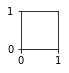

In [116]:
plt.figure(figsize=(8,50)) # not shown in the book
for iteration in range(n_digits):
    plt.subplot(n_digits, 10, iteration + 1)
    plot_image(outputs_val[iteration])

- 숫자들의 대부분은 꽤 신빙성이 있지만 몇 개는 창의적 
- autoencoder는 학습을 한 지 한시간도 안되었기 때문에 더 나은 성능을 충분히 기대할 수 있음 

## Other Autoencoders
- 새로운 autoencoder의 구조나 다른 비지도학습 알고리즘들도 정기적으로 등장하는 중 
### - 다른 종류의 autoencoder들에 대한 간략한 개요 
#### - Contractive autoencoder
- autoencoder는 학습중에 입력과 관련된 coding의 부산물을 찾도록 학습됨 
- 두개의 비슷한 입력은 반드시 비슷한 coding을 가짐 


#### - Stacked convolutional autoencoders
- convolutional 레이어를 통해 영상을 복원하여 시각 특징을 추출하도록 autoencoder를 학습 

#### - Generative stochastic network
- 데이터 생성 기능이 추가된 일반화된 denosing autoencoder

#### - Winner-take-all autoencoder
- 학습 중에, coding레이어의 모든 뉴런의 활성화를 계산
- 학습 batch에 대해 상위 k%의 활성화를 가진 뉴런만 보존, 나머지는 0으로 설정 (자연스럽게 sparse coding이 됨)
- 비슷한 WTA는 sparse convolutional autoencoder를 생산하는데 사용할 수 있음 


#### - Adversarial autoencoders
- 한 망을 입력 재생산하도록 학습, 동시에 다른 망은 첫번째 망이 제대로 복원할 수 없는 입력을 찾음 
    - 첫번째 autoencoder가 탄탄한 coding을 학습할 수 있도록 함 